In [2]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import os


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import acquire
import prepare

# Project Overview
### Explore the Telco Dataset to make sense of all the data
# Goals
### Trim the Dataset into a manageable size 
### Explore relationships between features and try and extract patterns
### Try to isolate confounding features and see if we can identify drivers of Churn
### Model based on these findings to see if we can predict customers that will churn
### We are going to use the specificity of the models since we are looking to isolate who might leave Telco
### Our positive is customers who stay and our negative is customers who leave so we will prioritize the specificity of our models over accuracy.  That said we will also have accuracy optimized models to show the difference.

In [3]:
#Prepare the Telco dataframe from prepare.py which gets rid of redundant columns and creates dummy variables where needed
#The alternative prep does not drop the month-to-month column like the original prep does.
telco = prepare.prep_telco_alternative()

In [4]:
telco.churn_Yes.value_counts()

0    5174
1    1869
Name: churn_Yes, dtype: int64

In [5]:
baseline = telco[telco.churn_Yes == 0]
churn = telco[telco.churn_Yes == 1]
len(baseline)/len(telco)

0.7346301292063041

###  On the surface we might use this as a baseline because it represents the frequency of the mode which is customers who don't churn.  As I have defined it, our positive result is customers who do not leave (i.e. don't churn) while our negative result are the customers who do churn (or leave).  

### Given this and the fact that we are specifically interested in the customers who are leaving, I am not using accuracy as my metric but rather the specificity of the models! 

### The specificity is $\frac{True Negatives}{False Positives + True Negatives}$  In other words what percent of the actual negatives do we catch with out predicted negatives.  This registers as the recall of the 1's in the churn_Yes column as opposed to the recall of the churn 0's.

### Thus the baseline specificity of this situation is assuming everyone is the mode or customers who stay and calculating the result: $\frac{True Negatives}{False Positives + True Negatives}$ = $\frac{0}{1869 + 0}$ = $0$

In [6]:
new_baseline = 0
new_baseline

0

### However if we were to just pick a customer at random there is a $\frac{1869}{7043}$ = 0.2653698707936959 chance that this customer will leave.  This is the real number to beat.  Note that our random pick is significantly more restrictive than the new_baseline so this is what we will use.

In [7]:
#Percent of customers that churn and thus if we were to pick any at random this is the chance that they would churn
real_number_to_beat = len(churn)/len(telco)
real_number_to_beat

0.2653698707936959

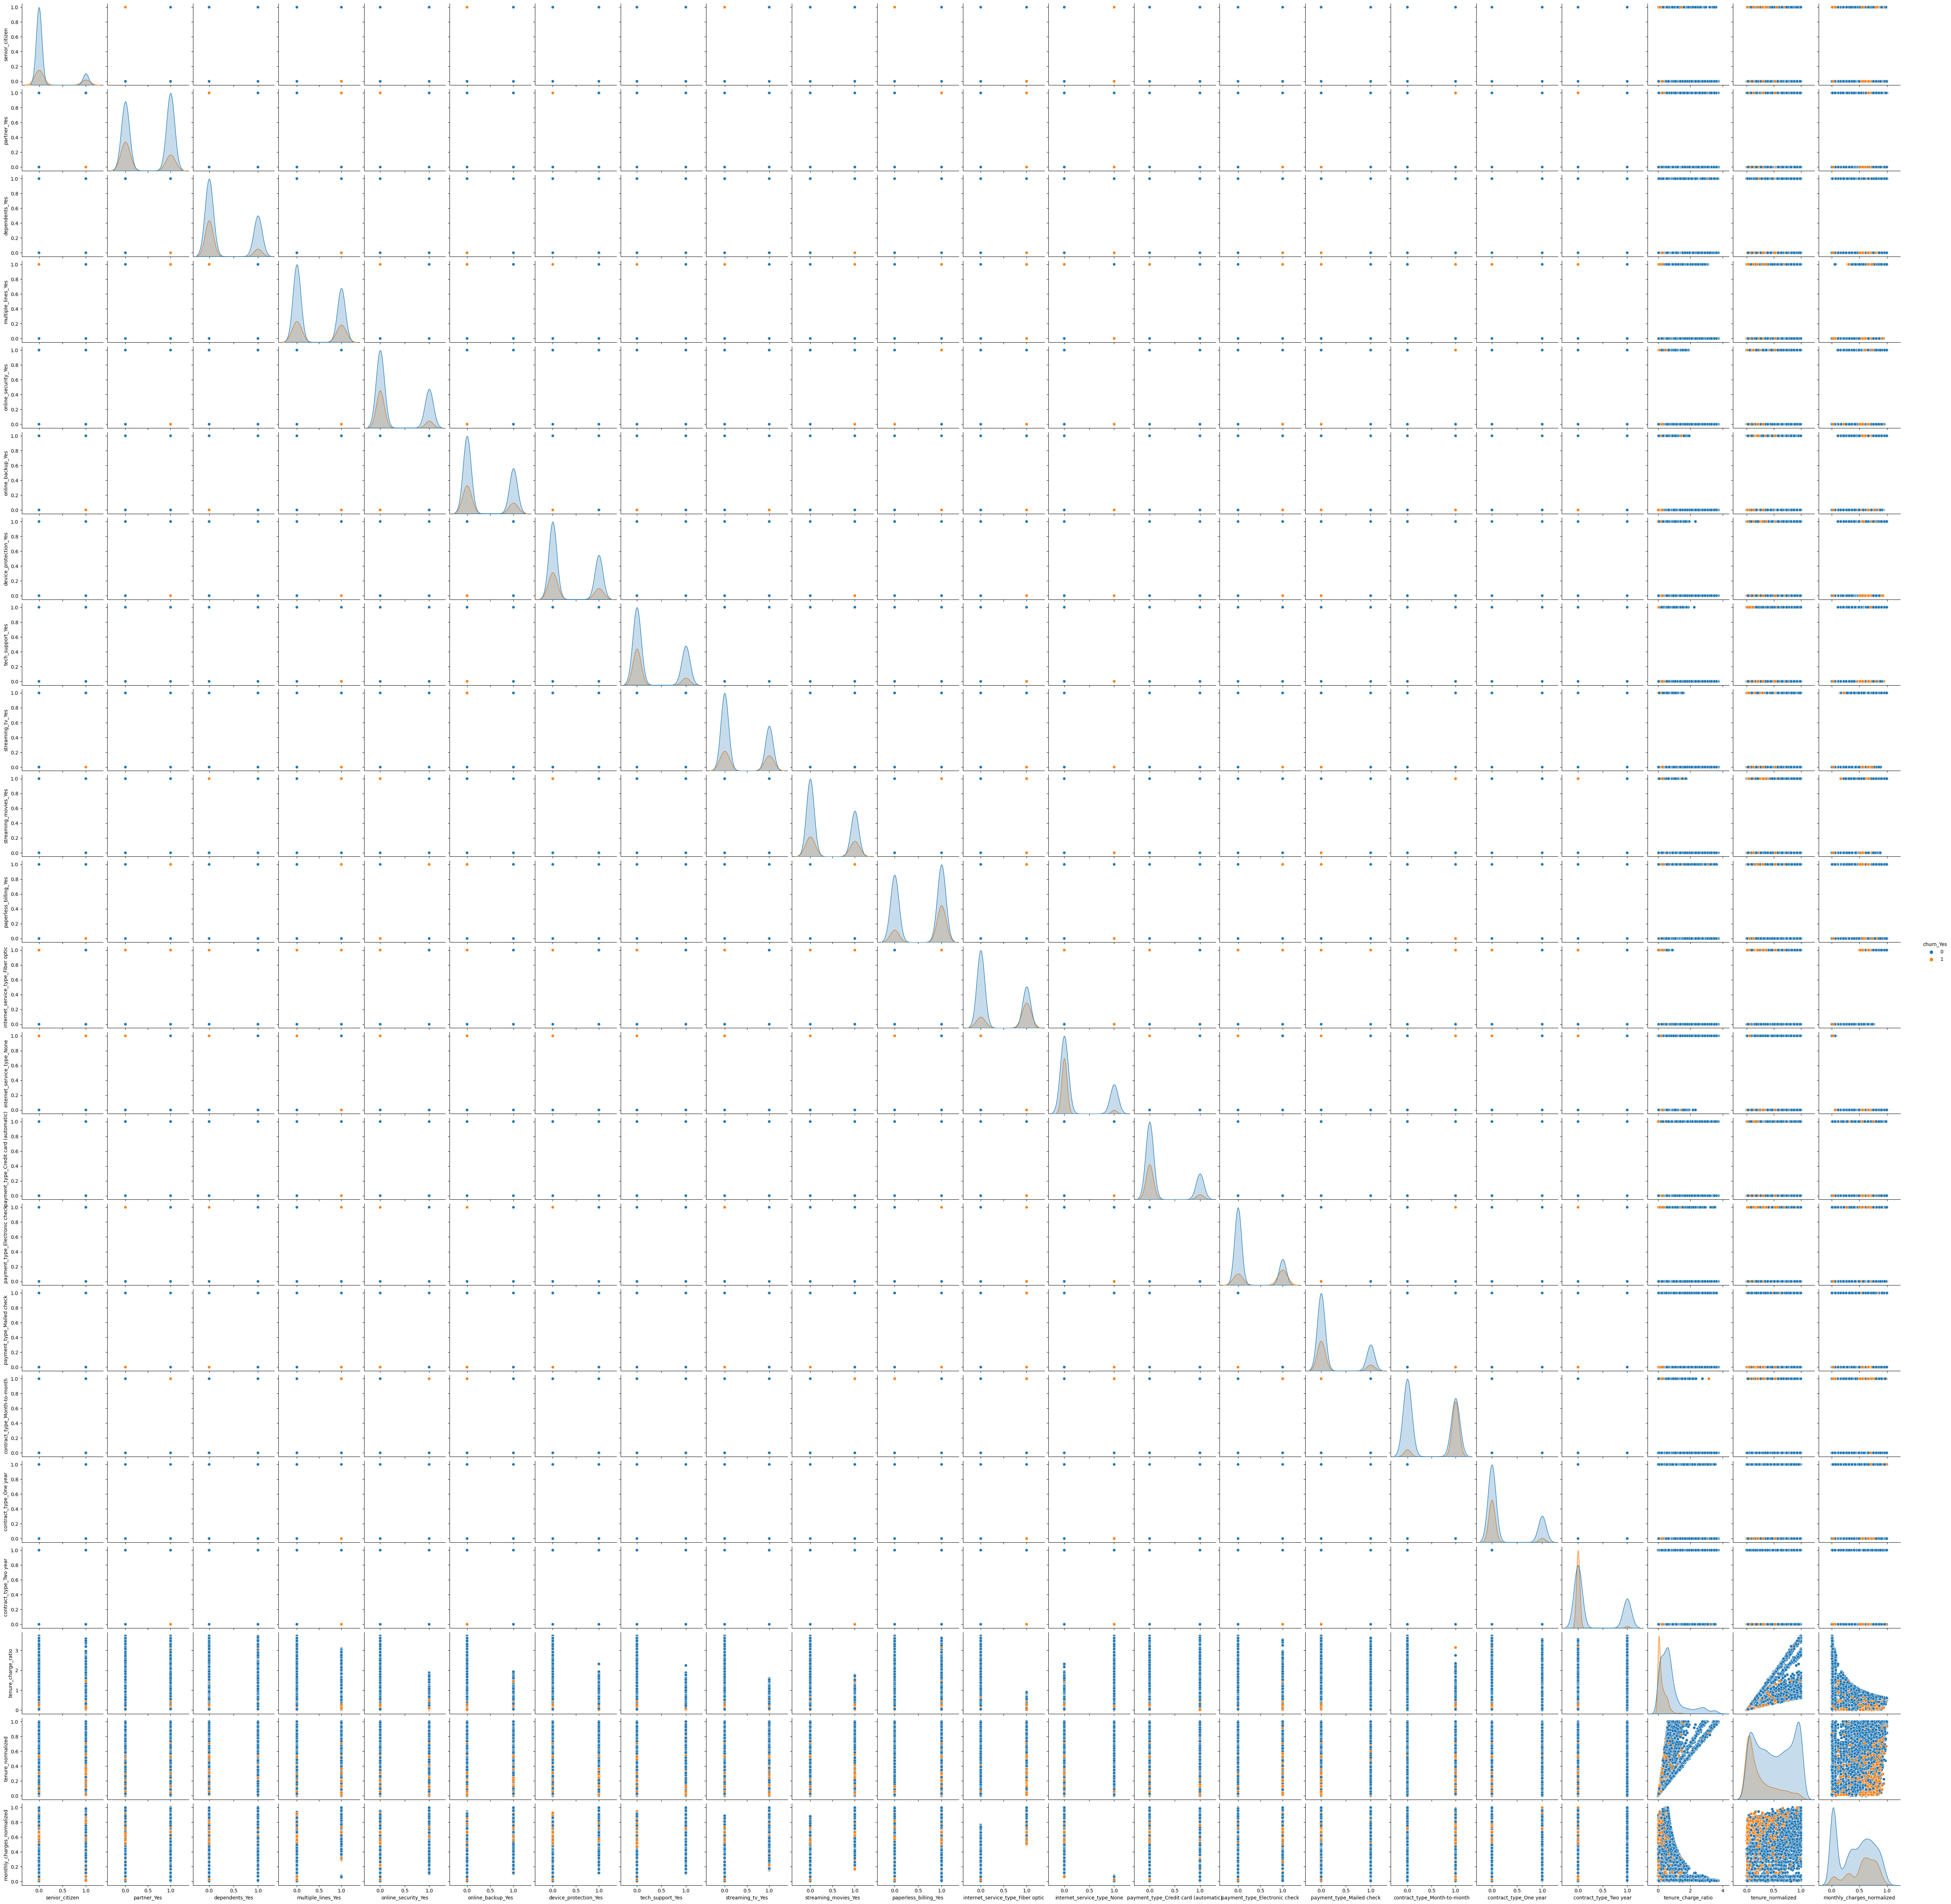

In [448]:
sns.pairplot(telco, hue='churn_Yes')

### Chi Squared Test for dependence for all columns
### Generalized Null Hypothesis:  The column in question and churn_Yes are independent of each other
### Generalized Alternative Hypothesis:  The column in question and churn_Yes have a dependent relationship
### Alpha < 0.01

In [8]:
#For loop to get the Chi Squared result for all the columns
for col in telco.columns:
    col = pd.crosstab(telco[col], telco.churn_Yes)
    print(col)
    col_chi2, col_p, col_degf, col_expected = stats.chi2_contingency(col)
    print(f'(chi squared = {col_chi2}, p = {col_p}')
    print('___________________________________________________________')

#IGNORE the CONTINOUS variable monthly charges even though it breaks it up into categores

churn_Yes   0  1
Unnamed: 0      
0           1  0
1           1  0
2           0  1
3           0  1
4           0  1
...        .. ..
7038        1  0
7039        0  1
7040        1  0
7041        1  0
7042        1  0

[7043 rows x 2 columns]
(chi squared = 7043.0, p = 0.49439767459438705
___________________________________________________________
churn_Yes          0     1
senior_citizen            
0               4508  1393
1                666   476
(chi squared = 159.42630036838742, p = 1.510066805092378e-36
___________________________________________________________
churn_Yes    0    1
tenure             
0           11    0
1          233  380
2          115  123
3          106   94
4           93   83
5           69   64
6           70   40
7           80   51
8           81   42
9           73   46
10          71   45
11          68   31
12          79   38
13          71   38
14          52   24
15          62   37
16          52   28
17          61   26
18          73   2

### "Unnamed: 0", "gender_male", "phone_service_Yes", "multiple_lines_No phone service" all do not meet the p-value we set and thus we do not have sufficient evidence to reject the null hypothesis.  Therefore I am dropping them all from the analysis.  "Unnamed: 0" is just an id number so it makes sense that they are independant events...kinda goes without saying but a good sanity check.

In [9]:
#Drop the columns that do not show dependence on churn
telco = telco.drop(columns=['Unnamed: 0', 'gender_Male', 'phone_service_Yes', 'multiple_lines_No phone service'])

[Text(0.5, 1.0, 'Is There a Relationship Between our Two Continuous Variables?')]

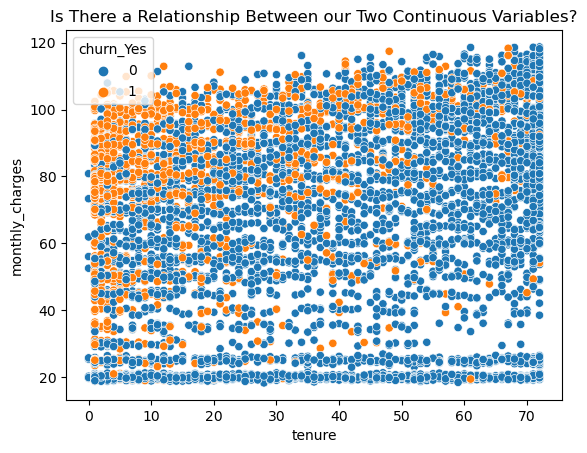

In [10]:
sns.scatterplot(data=telco, x='tenure', y='monthly_charges', hue='churn_Yes').set(title='Is There a Relationship Between our Two Continuous Variables?')

### This scatterplot seemed to show a clear relationship in a multivariable sense...The newer the Customer AND the more the customer paid seemed to have a clear impact on Churn Rates!

In [11]:
#Mask for churned customer so as to see them alone in the Scatter Plot
telco_churn = telco[telco.churn_Yes == 1]

[Text(0.5, 1.0, 'Is there a Correlation for Churned Customers?')]

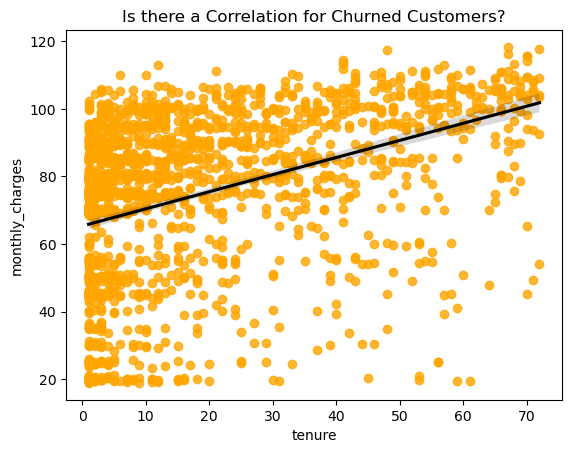

In [12]:
sns.regplot(data=telco_churn, x='tenure', y='monthly_charges', scatter_kws={'color':'orange'}, line_kws={'color':'black'}).set(title='Is there a Correlation for Churned Customers?')

### Looking at the tenure vs monthly_charges graph it seemed as though there were a correlation between tenure and monthly_charges for churned customers.  I masked the telco for churned customers and tried to see if there was a correlation.

### Null Hypothesis:  There is no linear correlation between the tenure and monthly charges
### Alternative Hypothesis:  There is a linear correlation
### choose an alpha < 0.05

In [13]:
stats.pearsonr(telco_churn.tenure, telco_churn.monthly_charges)

PearsonRResult(statistic=0.401285600132126, pvalue=3.0121978116585465e-73)

### The Pearson's test shows a p-value low enough to reject the null and see there is a linar correlation of .401 which is a moderate correlation.  A Spearman's test might show even stronger since it seems a monotonically increasing curve would fit even better.

### Null Hypothesis:  There is a no monotonic correlation between tenure and monthly charges
### Alt Hypothesis:  There is a monotonic correlation between tenure and monthly charges
### Alpha < 0.05

In [14]:
stats.spearmanr(telco_churn.tenure, telco_churn.monthly_charges, axis=0)

SignificanceResult(statistic=0.4843751919531249, pvalue=1.5136016239109236e-110)

### As expected the Spearman's test gives a very low p-value suggesting that we can reject the null and shows an even stronger correlation of .484.  Inspection of the graph clearly indicates that it is monotonically increasing.

###  These two results combined suggest that it might prove valuable to combine the two metrics into a new one.  I created a new column called tenure_charge_ratio which is the tenure divided by monthly charges

### Also, I normalized the tenure and monthly charges so as to optimize the knn predictions.  These should not have an adverse effect of trees random forests or the logistic regression models as the calculations are scaled accordingly.  In addition the logistic regression should be simplified as well.

In [15]:
#Create new tenure_charge_ratio Column
telco['tenure_charge_ratio'] = telco.tenure/telco.monthly_charges
#Normalize tenure and monthly charges so as not to throw off KNN under Manhattan Distance
telco['tenure_normalized'] = (telco.tenure - telco.tenure.min()) / (telco.tenure.max() - telco.tenure.min())
telco['monthly_charges_normalized'] = (telco.monthly_charges - telco.monthly_charges.min()) / (telco.monthly_charges.max() - telco.monthly_charges.min())
#Drop old tenure and monthly_charges columns
telco = telco.drop(columns=['tenure', 'monthly_charges'])
telco

,senior_citizen,partner_Yes,dependents_Yes,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,...,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,tenure_charge_ratio,tenure_normalized,monthly_charges_normalized
0,0,1,1,0,0,1,0,1,1,0,...,0,0,0,1,0,1,0,0.137195,0.125000,0.471144
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0.150250,0.125000,0.414428
2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0.054127,0.055556,0.553731
3,1,1,0,0,0,1,1,0,1,1,...,0,0,1,0,1,0,0,0.132653,0.180556,0.793532
4,1,1,0,0,0,0,0,1,1,0,...,0,0,0,1,1,0,0,0.035757,0.041667,0.653234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0.235721,0.180556,0.367164
7039,0,1,0,1,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0.258519,0.305556,0.665174
7040,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0.039761,0.027778,0.318905
7041,0,1,1,0,1,0,1,1,0,1,...,0,0,0,1,0,0,1,0.987472,0.930556,0.493532


### A quick Chi Squared test comparing the new column with the churn_Yes column
### Null hypothesis:  The tenure_charge_ratio and the churn_Yes columns are independent
### Alt hypothesis:  The tenure_charge_ratio and the churn_Yes columns are independent
### Alpha < 0.05

In [16]:
#Chi Squared test for new metric tenure_charge_ratio and churn_Yes
ratio = pd.crosstab(telco.tenure_charge_ratio, telco.churn_Yes)
ratio_chi2, ratio_p, ratio_degf, ratio_expected = stats.chi2_contingency(ratio)
ratio_chi2, ratio_p

(6322.159485046925, 0.005930175959581971)

### With a p-value of .006 we can reject the null and conclude that there is a dependence that we may take advantage of.

[Text(0.5, 1.0, 'Who Churns?')]

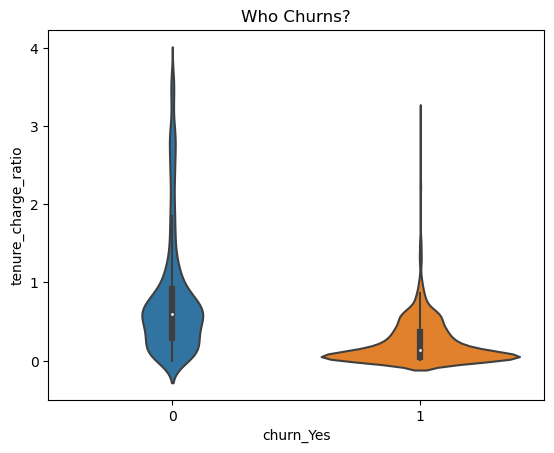

In [17]:
#Violin Plot shows this relationship best!
sns.violinplot(data=telco, x='churn_Yes', y='tenure_charge_ratio').set(title='Who Churns?')

### A quick violin plot shows that the churn rate is very high when the tenure_charge_ratio is low.

### When looking at Logistic Regression I really tried to eliminate all the Confounding variables and find the independent columns that really drove the Churn Rate.  I came up with Month-to-Month and the Fiber optic customers that were the most unsatisfied.

In [18]:
#Create a telco_drivers DataFrame for simplified analysis
telco_drivers = telco.drop(columns=['senior_citizen', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'internet_service_type_None',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
       'payment_type_Mailed check',
       'contract_type_One year', 'contract_type_Two year', 'tenure_normalized',
       'monthly_charges_normalized', 'tenure_charge_ratio'])
telco_drivers.columns

Index(['churn_Yes', 'internet_service_type_Fiber optic',
       'contract_type_Month-to-month'],
      dtype='object')

In [19]:
#Set up empty lists to fill for chart below
sensitivity_train = []
sensitivity_validate = []
accuracy_train = []
accuracy_validate = []

# Decision Tree

[0 0 0 0 0]
[[0.63736264 0.36263736]
 [0.63736264 0.36263736]
 [0.63736264 0.36263736]
 [0.83804627 0.16195373]
 [0.96358543 0.03641457]]


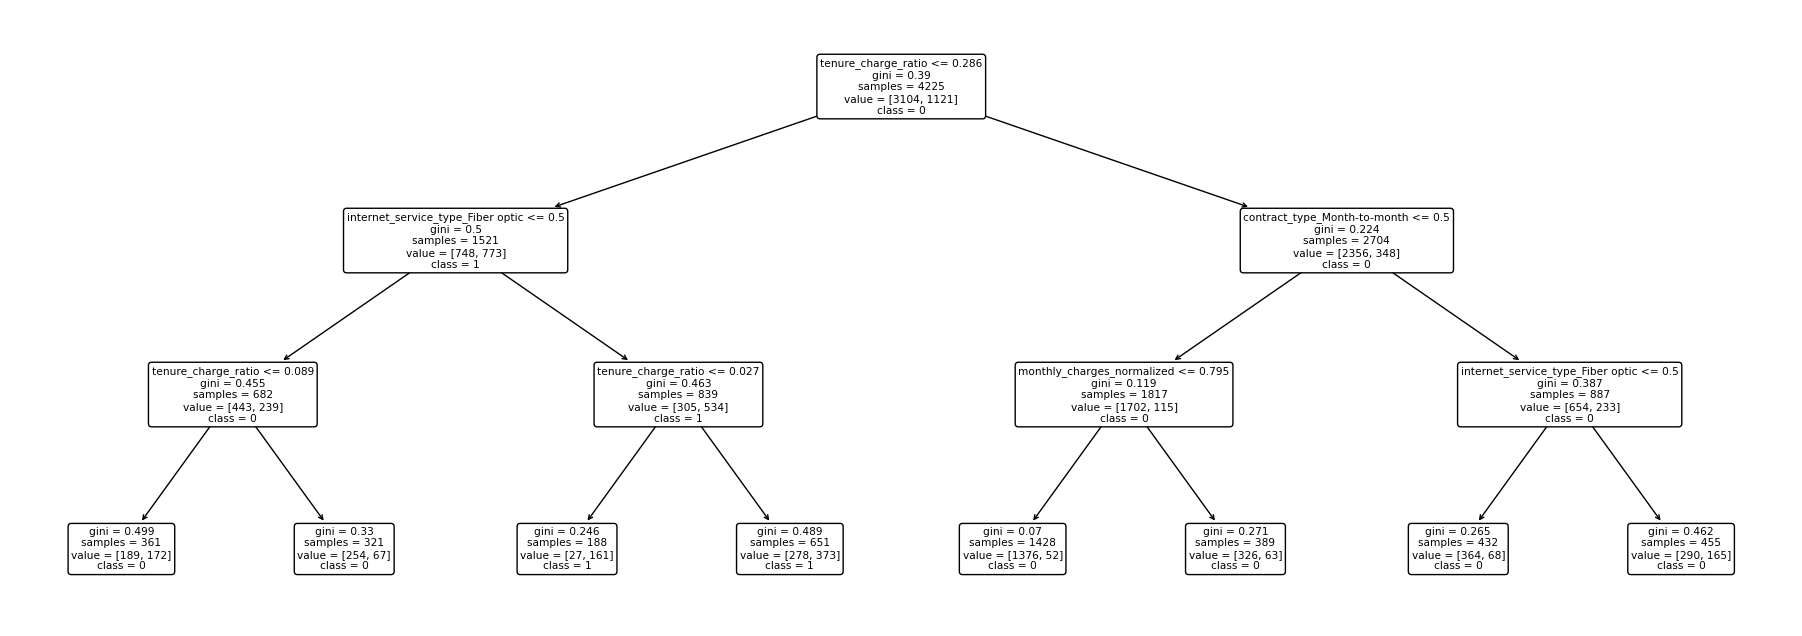

In [20]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco, 'churn_Yes')

clf = DecisionTreeClassifier(max_depth=3, random_state=823)
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(23, 8))
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_.astype('str'), rounded=True)

y_pred_clf = clf.predict(X_train)
print(y_pred_clf[0:5])
y_pred_proba_clf = clf.predict_proba(X_train)
print(y_pred_proba_clf[0:5])
y_val_clf = clf.predict(X_validate)
y_val_proba_clf = clf.predict_proba(X_validate)

In [21]:
print(confusion_matrix(y_train, y_pred_clf))
print(classification_report(y_train, y_pred_clf))
print(confusion_matrix(y_validate, y_val_clf))
print(classification_report(y_validate, y_val_clf))

[[2799  305]
 [ 587  534]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3104
           1       0.64      0.48      0.54      1121

    accuracy                           0.79      4225
   macro avg       0.73      0.69      0.70      4225
weighted avg       0.78      0.79      0.78      4225

[[914 121]
 [199 175]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1035
           1       0.59      0.47      0.52       374

    accuracy                           0.77      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.77      0.76      1409



### Sensitivities and Accuracies to Append to the Lists

In [22]:
sensitivity_decision_tree_train = confusion_matrix(y_train, y_pred_clf)[1][1]/(confusion_matrix(y_train, y_pred_clf)[1][0] + confusion_matrix(y_train, y_pred_clf)[1][1])
sensitivity_decision_tree_validate = confusion_matrix(y_validate, y_val_clf)[1][1]/(confusion_matrix(y_validate, y_val_clf)[1][0] + confusion_matrix(y_validate, y_val_clf)[1][1])

print(f'Sensitivity of Decision Tree classifier on training set with max depth 3: {sensitivity_decision_tree_train}')
print(f'Sensitivity of Decision Tree classifier on validate set with max depth 3: {sensitivity_decision_tree_validate}')

sensitivity_train.append(sensitivity_decision_tree_train)
sensitivity_validate.append(sensitivity_decision_tree_validate)

decision_tree_train_score= clf.score(X_train, y_train)
decision_tree_validate_score = clf.score(X_validate, y_validate)

print(f'Accuracy of Decision Tree classifier on training set with max depth 3: {decision_tree_train_score}')
print(f'Accuracy of Decision Tree classifier on validate set with max depth 3: {decision_tree_validate_score}')

accuracy_train.append(decision_tree_train_score)
accuracy_validate.append(decision_tree_validate_score)

Sensitivity of Decision Tree classifier on training set with max depth 3: 0.47636039250669043
Sensitivity of Decision Tree classifier on validate set with max depth 3: 0.4679144385026738
Accuracy of Decision Tree classifier on training set with max depth 3: 0.7888757396449704
Accuracy of Decision Tree classifier on validate set with max depth 3: 0.772888573456352


# Decision Tree with Drivers

[1 1 1 0 0]
[[0.45189274 0.54810726]
 [0.45189274 0.54810726]
 [0.45189274 0.54810726]
 [0.86340641 0.13659359]
 [0.96722561 0.03277439]]


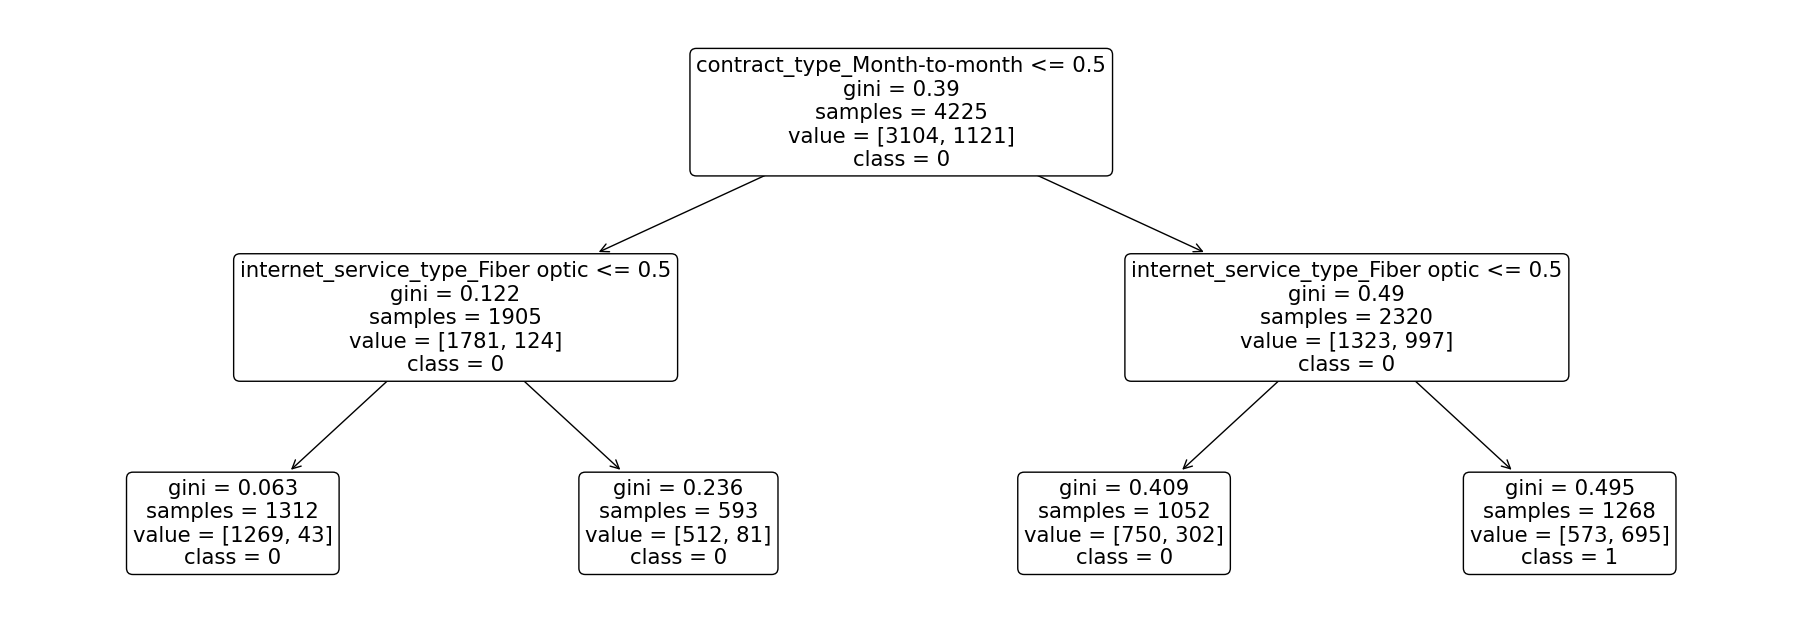

In [23]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_drivers, 'churn_Yes')

clf = DecisionTreeClassifier(max_depth=3, random_state=823)
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(23, 8))
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_.astype('str'), rounded=True)

y_pred_clf = clf.predict(X_train)
print(y_pred_clf[0:5])
y_pred_proba_clf = clf.predict_proba(X_train)
print(y_pred_proba_clf[0:5])
y_val_clf = clf.predict(X_validate)
y_val_proba_clf = clf.predict_proba(X_validate)

In [24]:
print(confusion_matrix(y_train, y_pred_clf))
print(classification_report(y_train, y_pred_clf))
print(confusion_matrix(y_validate, y_val_clf))
print(classification_report(y_validate, y_val_clf))

[[2531  573]
 [ 426  695]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3104
           1       0.55      0.62      0.58      1121

    accuracy                           0.76      4225
   macro avg       0.70      0.72      0.71      4225
weighted avg       0.77      0.76      0.77      4225

[[820 215]
 [140 234]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1035
           1       0.52      0.63      0.57       374

    accuracy                           0.75      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.77      0.75      0.75      1409



### Sensitivities and Accuracies to Append to the Lists

In [25]:
driver_sensitivity_decision_tree_train = confusion_matrix(y_train, y_pred_clf)[1][1]/(confusion_matrix(y_train, y_pred_clf)[1][0] + confusion_matrix(y_train, y_pred_clf)[1][1])
driver_sensitivity_decision_tree_validate = confusion_matrix(y_validate, y_val_clf)[1][1]/(confusion_matrix(y_validate, y_val_clf)[1][0] + confusion_matrix(y_validate, y_val_clf)[1][1])

print(f'Sensitivity of Decision Tree classifier on training set with max depth 3: {driver_sensitivity_decision_tree_train}')
print(f'Sensitivity of Decision Tree classifier on validate set with max depth 3: {driver_sensitivity_decision_tree_validate}')

sensitivity_train.append(driver_sensitivity_decision_tree_train)
sensitivity_validate.append(driver_sensitivity_decision_tree_validate)

driver_decision_tree_train_score= clf.score(X_train, y_train)
driver_decision_tree_validate_score = clf.score(X_validate, y_validate)

print(f'Accuracy of Decision Tree classifier on training set with max depth 3: {driver_decision_tree_train_score}')
print(f'Accuracy of Decision Tree classifier on validate set with max depth 3: {driver_decision_tree_validate_score}')

accuracy_train.append(driver_decision_tree_train_score)
accuracy_validate.append(driver_decision_tree_validate_score)

Sensitivity of Decision Tree classifier on training set with max depth 3: 0.6199821587867975
Sensitivity of Decision Tree classifier on validate set with max depth 3: 0.6256684491978609
Accuracy of Decision Tree classifier on training set with max depth 3: 0.7635502958579882
Accuracy of Decision Tree classifier on validate set with max depth 3: 0.7480482611781405


# Random Forrest

In [26]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco, 'churn_Yes')

rf = RandomForestClassifier(bootstrap=True,
                            class_weight=None,
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=18,
                            max_depth=8,
                            random_state=823)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict(X_train)
print(y_pred_rf[0:10])
y_pred_proba_rf = rf.predict_proba(X_train)
print(y_pred_proba_rf)
y_val_rf = rf.predict(X_validate)
y_val_proba_rf = rf.predict_proba(X_validate)

[0 0 0 0 0 0 0 0 0 0]
[[0.53951899 0.46048101]
 [0.80233723 0.19766277]
 [0.61361259 0.38638741]
 ...
 [0.98111439 0.01888561]
 [0.87247082 0.12752918]
 [0.73584328 0.26415672]]


In [27]:
print(confusion_matrix(y_train, y_pred_rf))
print(classification_report(y_train, y_pred_rf))
print(confusion_matrix(y_validate, y_val_rf))
print(classification_report(y_validate, y_val_rf))

[[2877  227]
 [ 477  644]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3104
           1       0.74      0.57      0.65      1121

    accuracy                           0.83      4225
   macro avg       0.80      0.75      0.77      4225
weighted avg       0.83      0.83      0.83      4225

[[930 105]
 [184 190]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.64      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.79      1409



### Sensitivities and Accuracies to Append to the Lists

In [28]:
sensitivity_random_forrest_train = confusion_matrix(y_train, y_pred_rf)[1][1]/(confusion_matrix(y_train, y_pred_rf)[1][0] + confusion_matrix(y_train, y_pred_rf)[1][1])
sensitivity_random_forrest_validate = confusion_matrix(y_validate, y_val_rf)[1][1]/(confusion_matrix(y_validate, y_val_rf)[1][0] + confusion_matrix(y_validate, y_val_rf)[1][1])

print(f'Sensitivity of Decision Tree classifier on training set with max depth 3: {sensitivity_random_forrest_train}')
print(f'Sensitivity of Decision Tree classifier on validate set with max depth 3: {sensitivity_random_forrest_validate}')

sensitivity_train.append(sensitivity_random_forrest_train)
sensitivity_validate.append(sensitivity_random_forrest_validate)

random_forrest_train_score= rf.score(X_train, y_train)
random_forrest_validate_score = rf.score(X_validate, y_validate)

print(f'Accuracy of Decision Tree classifier on training set with max depth 3: {random_forrest_train_score}')
print(f'Accuracy of Decision Tree classifier on validate set with max depth 3: {random_forrest_validate_score}')

accuracy_train.append(random_forrest_train_score)
accuracy_validate.append(random_forrest_validate_score)

Sensitivity of Decision Tree classifier on training set with max depth 3: 0.5744870651204282
Sensitivity of Decision Tree classifier on validate set with max depth 3: 0.5080213903743316
Accuracy of Decision Tree classifier on training set with max depth 3: 0.8333727810650887
Accuracy of Decision Tree classifier on validate set with max depth 3: 0.794889992902768


# Random Forrest with Drivers

In [29]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_drivers, 'churn_Yes')

rf = RandomForestClassifier(bootstrap=True,
                            class_weight=None,
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=18,
                            max_depth=8,
                            random_state=823)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_train)
print(y_pred_rf[0:10])
y_pred_proba_rf = rf.predict_proba(X_train)
print(y_pred_proba_rf)
y_val_rf = rf.predict(X_validate)
y_val_proba_rf = rf.predict_proba(X_validate)

[1 1 1 0 0 0 0 0 0 0]
[[0.45019005 0.54980995]
 [0.45019005 0.54980995]
 [0.45019005 0.54980995]
 ...
 [0.96733861 0.03266139]
 [0.70938875 0.29061125]
 [0.85816463 0.14183537]]


In [30]:
print(confusion_matrix(y_train, y_pred_rf))
print(classification_report(y_train, y_pred_rf))
print(confusion_matrix(y_validate, y_val_rf))
print(classification_report(y_validate, y_val_rf))

[[2531  573]
 [ 426  695]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3104
           1       0.55      0.62      0.58      1121

    accuracy                           0.76      4225
   macro avg       0.70      0.72      0.71      4225
weighted avg       0.77      0.76      0.77      4225

[[820 215]
 [140 234]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1035
           1       0.52      0.63      0.57       374

    accuracy                           0.75      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.77      0.75      0.75      1409



### Sensitivities and Accuracies to Append to the Lists

In [31]:
driver_sensitivity_random_forrest_train = confusion_matrix(y_train, y_pred_rf)[1][1]/(confusion_matrix(y_train, y_pred_rf)[1][0] + confusion_matrix(y_train, y_pred_rf)[1][1])
driver_sensitivity_random_forrest_validate = confusion_matrix(y_validate, y_val_rf)[1][1]/(confusion_matrix(y_validate, y_val_rf)[1][0] + confusion_matrix(y_validate, y_val_rf)[1][1])

print(f'Sensitivity of Decision Tree classifier on training set with max depth 3: {driver_sensitivity_random_forrest_train}')
print(f'Sensitivity of Decision Tree classifier on validate set with max depth 3: {driver_sensitivity_random_forrest_validate}')

sensitivity_train.append(driver_sensitivity_random_forrest_train)
sensitivity_validate.append(driver_sensitivity_random_forrest_validate)

driver_random_forrest_train_score= rf.score(X_train, y_train)
driver_random_forrest_validate_score = rf.score(X_validate, y_validate)

print(f'Accuracy of Decision Tree classifier on training set with max depth 3: {driver_random_forrest_train_score}')
print(f'Accuracy of Decision Tree classifier on validate set with max depth 3: {driver_random_forrest_validate_score}')

accuracy_train.append(driver_random_forrest_train_score)
accuracy_validate.append(driver_random_forrest_validate_score)

Sensitivity of Decision Tree classifier on training set with max depth 3: 0.6199821587867975
Sensitivity of Decision Tree classifier on validate set with max depth 3: 0.6256684491978609
Accuracy of Decision Tree classifier on training set with max depth 3: 0.7635502958579882
Accuracy of Decision Tree classifier on validate set with max depth 3: 0.7480482611781405


# KNN with K=10

In [32]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco, 'churn_Yes')
    
knn10 = KNeighborsClassifier(n_neighbors=15, weights='uniform', p=1)
knn10.fit(X_train, y_train)
    
y_pred_knn10 = knn10.predict(X_train)
y_pred_proba_knn10 = knn10.predict_proba(X_train)
    
y_val_knn10 = knn10.predict(X_validate)
y_val_proba_knn10 = knn10.predict_proba(X_validate)


print(y_pred_knn10[0:10])
print(y_pred_proba_knn10)

[1 0 1 0 0 0 0 0 0 0]
[[0.26666667 0.73333333]
 [0.53333333 0.46666667]
 [0.4        0.6       ]
 ...
 [0.93333333 0.06666667]
 [0.8        0.2       ]
 [0.86666667 0.13333333]]


In [33]:
print(confusion_matrix(y_train, y_pred_knn10))
print(classification_report(y_train, y_pred_knn10))
print(confusion_matrix(y_validate, y_val_knn10))
print(classification_report(y_validate, y_val_knn10))

[[2750  354]
 [ 439  682]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3104
           1       0.66      0.61      0.63      1121

    accuracy                           0.81      4225
   macro avg       0.76      0.75      0.75      4225
weighted avg       0.81      0.81      0.81      4225

[[886 149]
 [157 217]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1035
           1       0.59      0.58      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



### Sensitivities and Accuracies to Append to the Lists

In [34]:
sensitivity_knn10_train = confusion_matrix(y_train, y_pred_knn10)[1][1]/(confusion_matrix(y_train, y_pred_knn10)[1][0] + confusion_matrix(y_train, y_pred_knn10)[1][1])
sensitivity_knn10_validate = confusion_matrix(y_validate, y_val_knn10)[1][1]/(confusion_matrix(y_validate, y_val_knn10)[1][0] + confusion_matrix(y_validate, y_val_knn10)[1][1])

print(f'Sensitivity of Decision Tree classifier on training set with max depth 3: {sensitivity_knn10_train}')
print(f'Sensitivity of Decision Tree classifier on validate set with max depth 3: {sensitivity_knn10_validate}')

sensitivity_train.append(sensitivity_knn10_train)
sensitivity_validate.append(sensitivity_knn10_validate)

knn10_train_score= knn10.score(X_train, y_train)
knn10_validate_score = knn10.score(X_validate, y_validate)

print(f'Accuracy of Decision Tree classifier on training set with max depth 3: {knn10_train_score}')
print(f'Accuracy of Decision Tree classifier on validate set with max depth 3: {knn10_validate_score}')

accuracy_train.append(knn10_train_score)
accuracy_validate.append(knn10_validate_score)

Sensitivity of Decision Tree classifier on training set with max depth 3: 0.6083853702051739
Sensitivity of Decision Tree classifier on validate set with max depth 3: 0.5802139037433155
Accuracy of Decision Tree classifier on training set with max depth 3: 0.8123076923076923
Accuracy of Decision Tree classifier on validate set with max depth 3: 0.7828246983676366


# KNN K=15 with Drivers

In [35]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_drivers, 'churn_Yes')
    
knn15 = KNeighborsClassifier(n_neighbors=15, weights='uniform', p=1)
knn15.fit(X_train, y_train)
    
y_pred_knn15 = knn15.predict(X_train)
y_pred_proba_knn15 = knn15.predict_proba(X_train)
    
y_val_knn15 = knn15.predict(X_validate)
y_val_proba_knn15 = knn15.predict_proba(X_validate)



print(y_pred_knn15[0:10])
print(y_pred_proba_knn15)


[1 1 1 0 0 0 0 0 0 0]
[[0.46666667 0.53333333]
 [0.46666667 0.53333333]
 [0.46666667 0.53333333]
 ...
 [1.         0.        ]
 [0.6        0.4       ]
 [0.93333333 0.06666667]]


In [36]:
print(confusion_matrix(y_train, y_pred_knn15))
print(classification_report(y_train, y_pred_knn15))
print(confusion_matrix(y_validate, y_val_knn15))
print(classification_report(y_validate, y_val_knn15))

[[2531  573]
 [ 426  695]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3104
           1       0.55      0.62      0.58      1121

    accuracy                           0.76      4225
   macro avg       0.70      0.72      0.71      4225
weighted avg       0.77      0.76      0.77      4225

[[820 215]
 [140 234]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1035
           1       0.52      0.63      0.57       374

    accuracy                           0.75      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.77      0.75      0.75      1409



### Sensitivities and Accuracies to Append to the Lists

In [37]:
driver_sensitivity_knn15_train = confusion_matrix(y_train, y_pred_knn15)[1][1]/(confusion_matrix(y_train, y_pred_knn15)[1][0] + confusion_matrix(y_train, y_pred_knn15)[1][1])
driver_sensitivity_knn15_validate = confusion_matrix(y_validate, y_val_knn15)[1][1]/(confusion_matrix(y_validate, y_val_knn15)[1][0] + confusion_matrix(y_validate, y_val_knn15)[1][1])

print(f'Sensitivity of Decision Tree classifier on training set with max depth 3: {driver_sensitivity_knn15_train}')
print(f'Sensitivity of Decision Tree classifier on validate set with max depth 3: {driver_sensitivity_knn15_validate}')

sensitivity_train.append(driver_sensitivity_knn15_train)
sensitivity_validate.append(driver_sensitivity_knn15_validate)

driver_knn15_train_score= knn15.score(X_train, y_train)
driver_knn15_validate_score = knn15.score(X_validate, y_validate)

print(f'Accuracy of Decision Tree classifier on training set with max depth 3: {driver_knn15_train_score}')
print(f'Accuracy of Decision Tree classifier on validate set with max depth 3: {driver_knn15_validate_score}')

accuracy_train.append(driver_knn15_train_score)
accuracy_validate.append(driver_knn15_validate_score)

Sensitivity of Decision Tree classifier on training set with max depth 3: 0.6199821587867975
Sensitivity of Decision Tree classifier on validate set with max depth 3: 0.6256684491978609
Accuracy of Decision Tree classifier on training set with max depth 3: 0.7635502958579882
Accuracy of Decision Tree classifier on validate set with max depth 3: 0.7480482611781405


# Logistic Regression

In [38]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco, 'churn_Yes')

logit = LogisticRegression(C=1, random_state=823, intercept_scaling=1, max_iter=1000, solver='lbfgs')
logit.fit(X_train, y_train)
    
y_pred_logit = logit.predict(X_train)
y_pred_proba_logit = logit.predict_proba(X_train)
        
y_val_logit = logit.predict(X_validate)
y_val_proba_logit = logit.predict_proba(X_validate)
    


print(y_pred_logit[0:10])
print(y_pred_proba_logit)


[0 0 0 0 0 0 0 0 0 0]
[[0.52944612 0.47055388]
 [0.77109381 0.22890619]
 [0.65421696 0.34578304]
 ...
 [0.97755149 0.02244851]
 [0.86766828 0.13233172]
 [0.91165909 0.08834091]]


In [39]:
print(confusion_matrix(y_train, y_pred_logit))
print(classification_report(y_train, y_pred_logit))
print(confusion_matrix(y_validate, y_val_logit))
print(classification_report(y_validate, y_val_logit))

[[2793  311]
 [ 500  621]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3104
           1       0.67      0.55      0.60      1121

    accuracy                           0.81      4225
   macro avg       0.76      0.73      0.74      4225
weighted avg       0.80      0.81      0.80      4225

[[921 114]
 [172 202]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



### Sensitivities and Accuracies to Append to the Lists

In [40]:
sensitivity_logit_train = confusion_matrix(y_train, y_pred_logit)[1][1]/(confusion_matrix(y_train, y_pred_logit)[1][0] + confusion_matrix(y_train, y_pred_logit)[1][1])
sensitivity_logit_validate = confusion_matrix(y_validate, y_val_logit)[1][1]/(confusion_matrix(y_validate, y_val_logit)[1][0] + confusion_matrix(y_validate, y_val_logit)[1][1])

print(f'Sensitivity of Decision Tree classifier on training set with max depth 3: {sensitivity_logit_train}')
print(f'Sensitivity of Decision Tree classifier on validate set with max depth 3: {sensitivity_logit_validate}')

sensitivity_train.append(sensitivity_logit_train)
sensitivity_validate.append(sensitivity_logit_validate)

logit_train_score= logit.score(X_train, y_train)
logit_validate_score = logit.score(X_validate, y_validate)

print(f'Accuracy of Decision Tree classifier on training set with max depth 3: {logit_train_score}')
print(f'Accuracy of Decision Tree classifier on validate set with max depth 3: {logit_validate_score}')

accuracy_train.append(logit_train_score)
accuracy_validate.append(logit_validate_score)

Sensitivity of Decision Tree classifier on training set with max depth 3: 0.5539696699375558
Sensitivity of Decision Tree classifier on validate set with max depth 3: 0.5401069518716578
Accuracy of Decision Tree classifier on training set with max depth 3: 0.8080473372781065
Accuracy of Decision Tree classifier on validate set with max depth 3: 0.7970191625266146


# Logistic Regression with Drivers

In [41]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_drivers, 'churn_Yes')

logit = LogisticRegression(C=1, random_state=823, intercept_scaling=1, max_iter=1000, solver='lbfgs')
logit.fit(X_train, y_train)
    
y_pred_logit = logit.predict(X_train)
y_pred_proba_logit = logit.predict_proba(X_train)
        
y_val_logit = logit.predict(X_validate)
y_val_proba_logit = logit.predict_proba(X_validate)
    

print(y_pred_logit[0:10])
print(y_pred_proba_logit)


[1 1 1 0 0 0 0 0 0 0]
[[0.44588843 0.55411157]
 [0.44588843 0.55411157]
 [0.44588843 0.55411157]
 ...
 [0.95885647 0.04114353]
 [0.72225034 0.27774966]
 [0.8782248  0.1217752 ]]


In [42]:
print(confusion_matrix(y_train, y_pred_logit))
print(classification_report(y_train, y_pred_logit))
print(confusion_matrix(y_validate, y_val_logit))
print(classification_report(y_validate, y_val_logit))

[[2531  573]
 [ 426  695]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3104
           1       0.55      0.62      0.58      1121

    accuracy                           0.76      4225
   macro avg       0.70      0.72      0.71      4225
weighted avg       0.77      0.76      0.77      4225

[[820 215]
 [140 234]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1035
           1       0.52      0.63      0.57       374

    accuracy                           0.75      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.77      0.75      0.75      1409



### Sensitivities and Accuracies to Append to the Lists

In [43]:

driver_sensitivity_logit_train = confusion_matrix(y_train, y_pred_logit)[1][1]/(confusion_matrix(y_train, y_pred_logit)[1][0] + confusion_matrix(y_train, y_pred_logit)[1][1])
driver_sensitivity_logit_validate = confusion_matrix(y_validate, y_val_logit)[1][1]/(confusion_matrix(y_validate, y_val_logit)[1][0] + confusion_matrix(y_validate, y_val_logit)[1][1])

print(f'Sensitivity of Decision Tree classifier on training set with max depth 3: {driver_sensitivity_logit_train}')
print(f'Sensitivity of Decision Tree classifier on validate set with max depth 3: {driver_sensitivity_logit_validate}')

sensitivity_train.append(driver_sensitivity_logit_train)
sensitivity_validate.append(driver_sensitivity_logit_validate)

driver_logit_train_score= logit.score(X_train, y_train)
driver_logit_validate_score = logit.score(X_validate, y_validate)

print(f'Accuracy of Decision Tree classifier on training set with max depth 3: {driver_logit_train_score}')
print(f'Accuracy of Decision Tree classifier on validate set with max depth 3: {driver_logit_validate_score}')

accuracy_train.append(driver_logit_train_score)
accuracy_validate.append(driver_logit_validate_score)

Sensitivity of Decision Tree classifier on training set with max depth 3: 0.6199821587867975
Sensitivity of Decision Tree classifier on validate set with max depth 3: 0.6256684491978609
Accuracy of Decision Tree classifier on training set with max depth 3: 0.7635502958579882
Accuracy of Decision Tree classifier on validate set with max depth 3: 0.7480482611781405


In [44]:
#create a metrics_list DataFrame for ease of analysis and chart below
metrics_list = pd.DataFrame(
    {'sensitivity_train': sensitivity_train,
     'sensitivity_validate': sensitivity_validate,
     'accuracy_train': accuracy_train,
     'accuracy_validate': accuracy_validate
    })

#Create a dictionary so that I can rename the rows of the DataFrame
row_names = {0:'decision_tree',
             1:'decision_tree_with_driver',
             2:'random_forrest',
             3:'random_forrest_with_driver',
             4:'knn10',
             5:'knn15_with_driver',
             6:'logit',
             7:'logit_with_driver',
            }
#Does the actual renaming
metrics_list = metrics_list.rename(index = row_names)

#Add an accuracy_difference column
metrics_list['accuracy_difference'] = metrics_list.accuracy_train - metrics_list.accuracy_validate
metrics_list

,sensitivity_train,sensitivity_validate,accuracy_train,accuracy_validate,accuracy_difference
decision_tree,0.476360,0.467914,0.788876,0.772889,0.015987
decision_tree_with_driver,0.619982,0.625668,0.763550,0.748048,0.015502
random_forrest,0.574487,0.508021,0.833373,0.794890,0.038483
random_forrest_with_driver,0.619982,0.625668,0.763550,0.748048,0.015502
knn10,0.608385,0.580214,0.812308,0.782825,0.029483
knn15_with_driver,0.619982,0.625668,0.763550,0.748048,0.015502
logit,0.553970,0.540107,0.808047,0.797019,0.011028
logit_with_driver,0.619982,0.625668,0.763550,0.748048,0.015502


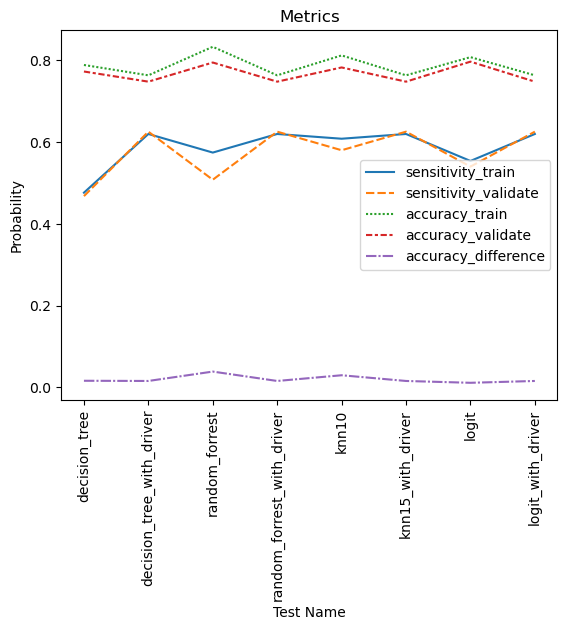

In [45]:
#Make a lineplot showing the relationships between the accuracies and the sensitivities. 
sns.lineplot(data=metrics_list).set(title='Metrics')

plt.legend(loc='center right')
plt.xlabel('Test Name')
plt.xticks(rotation=90)
plt.ylabel('Probability')
plt.show()

### Note that When Accuracy Dips the Sensitivity Peaks and Vice Versa

# Testing with logit_with driver

In [46]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_drivers, 'churn_Yes')

logit = LogisticRegression(C=1, random_state=823, intercept_scaling=1, max_iter=1000, solver='lbfgs')
logit.fit(X_train, y_train)
    
y_pred_log = logit.predict(X_train)
y_pred_proba_log = logit.predict_proba(X_train)
        
y_val_log = logit.predict(X_validate)
y_val_proba_log = logit.predict_proba(X_validate)

y_pred_test = logit.predict(X_test)
y_test_proba = logit.predict_proba(X_test)
    
print('TRAIN SET')
print(confusion_matrix(y_train, y_pred_log))
print(classification_report(y_train, y_pred_log))
print('VALIDATE SET')
print(confusion_matrix(y_validate, y_val_log))
print(classification_report(y_validate, y_val_log))
print('TEST SET')
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

y_test_pred_logit = logit.predict(X_test)
print(y_test_pred_logit[0:10])
y_test_pred_proba_logit = logit.predict_proba(X_test)
print(y_test_pred_proba_logit)

TRAIN SET
[[2531  573]
 [ 426  695]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3104
           1       0.55      0.62      0.58      1121

    accuracy                           0.76      4225
   macro avg       0.70      0.72      0.71      4225
weighted avg       0.77      0.76      0.77      4225

VALIDATE SET
[[820 215]
 [140 234]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1035
           1       0.52      0.63      0.57       374

    accuracy                           0.75      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.77      0.75      0.75      1409

TEST SET
[[857 178]
 [141 233]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1035
           1       0.57      0.62      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71

### Sensitivity is straight across the board so a chart is not needed.  It is clear that we have beat our baseline by a considerable amount.  Clearly the month-to-month contract and the Fiber Optic Service are things we need to look into.

In [47]:
#Recover the Customer ID's and turn into an np array

customer = prepare.prep_telco_with_customer_id()
customer_X_train, customer_y_train, customer_X_validate, customer_y_validate, customer_X_test, customer_y_test = prepare.split_data_label(customer, 'churn_Yes')

customer_id = customer_X_test.customer_id.tolist()

#Recover the churn column from y_test_pred_proba_logit
churn_probabilities = []
for row in y_test_pred_proba_logit:
    churn_probabilities.append(row[1])
    
#Create a dictionary of lists
export = {
    'customer_id': customer_id,
    'churn_probability': churn_probabilities,
    'churn_prediction': y_test_pred_logit,    
}

#Convert the three lists to a DataFrame
predictions = pd.DataFrame(export)

#Export to csv
predictions.to_csv('predictions1.csv', mode='w')

# Conclusion:
### I admittedly did not set goals properly when starting this project and just jumped right in.  I went all over the place but eventually came upon the proper answers.  The two main drivers of churn in terms of features were whether the customer had a month-to-month contract and whether the customer had fiber optic service.  These two alone seem to explain sixty two percent of the churning customers.  However qualitatively the newer the customer and the more they are paying per month, the higher the churn rate while longer term customers paying less seem to stay with the company.

### There are many confounding features that make this analysis hard but I believe I have found the foundation of the mass of churning customers.  The remaining thirty eight percent of the customers can be analized in a further study.

### As for the drivers that I found: Presumably the month-to-month contract is designed to entice new customers and thus will naturally have a higher churn rate.  Further inquiry into the phenomenon might provide insight into how to keep these customers i.e. giving them a discount or combining services in order to keep them.  However, there is something going on with Fiber Optic Service.  Perhaps it is expensive and customers don't feel it is worth the cost, or perhaps it is unreliable.  More information is needed in order to address these questions.